In [2]:
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using MPSKit
using TensorKit
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using ProgressMeter

using Combinatorics
using LaTeXStrings
using FileIO
using JLD2
Makie.inline!(true)
include("julia_functions.jl")



modify_approx_sizes_schimdt_compatible (generic function with 1 method)

Definition of the relevant transformation functions in the notebook below:

Transform the full tensornetwork to the tree structure by sequentially applying the transformation defined in taken path

But first - redefinition of all the relevant functions

In [3]:
# # Define the network and the relevant extraction and load and save them:
# # Act each time on the same tensor network !
# TN = generate_random_quantum_circuit_2d_2xn(2, 6, 5, 0.8)
# graph, tv_map, ie_map, weighted_edge_list, ei_map = extract_graph_representation(TN, false) # Extract the graphs.jl structure from the Tenet.TensorNetwork
# seperation_variables = [TN, graph, tv_map, ie_map, weighted_edge_list, ei_map]
# FileIO.save("transport variables/seperation_variables.jld2","A2", seperation_variables)

In [4]:
TN = generate_random_quantum_circuit_2d_4x4(4, 4 , 4 , 1)
graph, tv_map, ie_map, weighted_edge_list, ei_map = extract_graph_representation(TN)
# plot the graph structure of the initial graph

(SimpleGraph{Int64}(192, [[11, 12, 100], [70, 83, 84], [10, 109, 114], [107, 111, 112], [47, 51, 67], [7], [6, 33, 71], [9], [8, 30, 38], [3, 133, 135]  …  [10, 99, 114], [11, 18, 19], [54, 81, 82], [13, 20, 24], [61, 73, 74], [27, 28, 112], [26], [59, 81, 82], [44, 58, 59], [41, 42, 43]]), Dict{Int64, Tenet.Tensor}(5 => [-1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -1.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im;;; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im; -1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -1.0 + 0.0im], 56 => [-1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -1.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im;;; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im], 35 => [-1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -1.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im;;; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im], 55 => [-0.8775825618903728 + 0.0im 0.0 + 0.0i

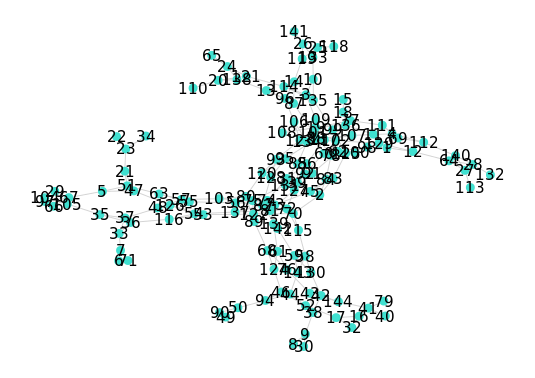

Amount of loops = 49


TN_tree_transform_approximate (generic function with 4 methods)

In [5]:

display(gplot(graph, nodelabel=[i for i in 1:nv(graph)], layout=spring_layout))
global memory_usage_throughout_approximation_process = []
global approximation_path = []

println("Amount of loops = ", length(minimum_cycle_basis(graph)))

function extract_partial_tn_loop(TN, index_cycle, printing = false)

    """
    Based on the index in the index cycle crop out a part of the tensor network
    and return this local LOOP-TensorNetwork.
    """
    tensors_in_loop = collect(Set([tensor for id in index_cycle for tensor in Tenet.select(TN, [id])])) #correct orderding of variable definitions

    current_tn = TensorNetwork(tensor for tensor in tensors_in_loop)
    if printing == true
        drawing1 = Makie.plot(current_tn, node_color=[:darkred for i in 1:length(tensors(current_tn))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end
        
    return current_tn
end

function collect_tensors_along_loop(loop_tn, index_cycle, index_to_cut)

    """
    Funtion whcih sequentially walks along the index cycle in the correct order
    loop and selects the relevant tensors.
    Return a list of tensors which is correctly ordered along the loop.
    """
    
    global start_tensor
    global end_tensor

    connectedtensors = Tenet.select(loop_tn, index_to_cut)
    firstsymbol = index_cycle[1]
    for tensor in connectedtensors
        if !isempty(intersect(inds(tensor), [firstsymbol]))
            global start_tensor = tensor
        else
            global end_tensor = tensor
        end
    end

    tensors_ordered_loop = []
    for i in 1:length(tensors(loop_tn))
        if i == length(tensors(loop_tn))
            push!(tensors_ordered_loop, end_tensor)
            return tensors_ordered_loop
        end
        if i == 1
            push!(tensors_ordered_loop, start_tensor)
            continue
        end
        connecting_id = intersect(inds(tensors_ordered_loop[i-1]), [Symbol(id) for id in index_cycle])
        next_tensor = [tensorc for tensorc in Tenet.select(loop_tn, connecting_id)  if tensorc != tensors_ordered_loop[i-1]][1]
        index_cycle = filter(x -> x != connecting_id[1], index_cycle)
        push!(tensors_ordered_loop, next_tensor)
    end
    
    return tensors_ordered_loop
end


function new_node_cycle(node_cycle::Vector{Int}, edge_to_cut::Tuple{Int, Int})

    """
    Put the node cycle in the correct ordering which places the node cycle
    in the correct form the extract the MPS.
    """
    
    for i in 1:length(node_cycle)
        node_perm = circshift( node_cycle, i-1)
        first_index = findfirst(x -> x == edge_to_cut[1], node_perm)
        second_index = findfirst(x -> x == edge_to_cut[2], node_perm)
        if sort([first_index, second_index]) == [1, length(node_cycle)]
            node_cycle = node_perm
            break
        end
    end
    return node_cycle
end

function Tenet_loop_2_Tenet_MPS(loop, index_cycle, index_to_cut, printing = false)
    global new_tn_tensors = []
    global contract_list = []
    global loop_size
    global propagating_iso_index
    global propagating_iso_split 
    global loop_index_propagation

    idx = findfirst(isequal(index_to_cut), index_cycle)
    mps_cycle = vcat(index_cycle[idx+1:end], index_cycle[1:idx-1])
    ordered_along_loop = collect_tensors_along_loop(loop, deepcopy(mps_cycle), index_to_cut)

    contract_first = []                                                         # implement the memory vibrations!!!! scale it up to large networks
    """
    Walk along the loop and make the necessary alterations at each step
    """
    new_virtual_inds = [Symbol("v$i") for i in 1:100]
    collect_virtual = []
    
    for (i, tensor) in enumerate(ordered_along_loop)
        if printing == true
            println("________________________Working on step = $i"*"_______________________________________")
            println(" Tensor $i  => ", inds(tensor), "with sizes", [size(tensor, id) for id in inds(tensor)])
        end

        # cases on the edges of the loop are treated seperately
        if i == 1
            global loop_size = [size(tensor, id) for id in inds(tensor) if id == Symbol(index_to_cut)][1]
            global loop_index_propagation = Symbol(index_to_cut)
            current_inds = inds(tensor)
            dangling_leg = setdiff(inds(tensor), [Symbol(id) for id in index_cycle])
            next_group_leg = setdiff(inds(tensor), [loop_index_propagation, dangling_leg[1]])[1]
            grouplegs = [loop_index_propagation, next_group_leg]            
            grouplegs_new = Symbol.(string.(grouplegs) .*repeat("_", i))
            new_t = replace_index(tensor, grouplegs, grouplegs_new)
            tensor_id = setdiff(inds(tensor), [Symbol(index_to_cut), dangling_leg[1]])[1]
            global propagating_iso_index = tensor_id
            tensor_size = size(tensor, tensor_id)
            grouping, splitting = random_unitary_tensor_and_random_unitary_inverse(loop_size, tensor_size, grouplegs_new, grouplegs, new_virtual_inds[i])
            push!(collect_virtual, new_virtual_inds[i])
            global propagating_iso_split = splitting

            if printing == true
                println("new_t = ", inds(new_t), "with sizes", [size(new_t, id) for id in inds(new_t)])
                println("grouping = ", inds(grouping), "with sizes", [size(grouping, id) for id in inds(grouping)])
            end

            push!(new_tn_tensors, new_t)
            push!(new_tn_tensors, grouping)
    
            continue
        end
    
    
        # general bulk case
        if 1 < i < length(ordered_along_loop)
            
            current_inds = inds(tensor)
            dangling_leg = setdiff(inds(tensor), [Symbol(id) for id in index_cycle])
            next_group_leg = setdiff(inds(tensor), [propagating_iso_index, dangling_leg[1]])[1]
            tensor_size = size(tensor, next_group_leg)
            
            grouplegs = [loop_index_propagation, next_group_leg]
            grouplegs_new = Symbol.(string.(grouplegs) .*repeat("_", i))
            push!(contract_first, grouplegs_new[2])
            new_t = replace_index(tensor, grouplegs, grouplegs_new)
            new_split = replace_index(propagating_iso_split, grouplegs, grouplegs_new)
    
            grouping, splitting = random_unitary_tensor_and_random_unitary_inverse(loop_size, tensor_size, grouplegs_new, grouplegs, new_virtual_inds[i])

            if printing == true
                println("new_split =", inds(new_split), "with sizes", [size(new_split, id) for id in inds(new_split)] )
                println("new_t = ", inds(new_t), "with sizes", [size(new_t, id) for id in inds(new_t)])
                println("grouping = ", inds(grouping), "with sizes", [size(grouping, id) for id in inds(grouping)])            
            end

            push!(new_tn_tensors, new_split)
            push!(new_tn_tensors, new_t)
            push!(new_tn_tensors, grouping)
            global propagating_iso_split = splitting
            global propagating_iso_index = next_group_leg
            push!(collect_virtual, new_virtual_inds[i])
    
            continue
        end
    
        if i == length(ordered_along_loop)
            push!(new_tn_tensors, propagating_iso_split)
            push!(new_tn_tensors, tensor)
        end
    
    end

    
    
    mps_network = Tenet.TensorNetwork(new_tn_tensors)
    contraction_list = inds(mps_network, :inner)
       
    contract_list = vcat(contract_first, setdiff(contraction_list, collect_virtual))
    
    for id in contract_list
        if id ∈ inds(mps_network)
            contraction_step(mps_network, id)
        end
    end
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    push!(memory_usage_throughout_approximation_process, current_mem_usage)
    println("after mps contraction current_mem_usage = ", current_mem_usage)

   
    return mps_network, collect_virtual
end

function compress_Tenet_MPS(TenetMPS, physical_order, inds_connecting, chi_max, printing = false, exact = false)

    println("___________Starting MPSKit conversion and compression___________")

    """
    Function which takes in a TenetMPS, a order of the physical indices,
    and a max allowed bond dimension chi_max. Compresses the TenetMPS using a conversion to MPSKit
    and DMRG variational compression. After compression reconverts to TenetMPS and returns
    the compressed TenetMPS.
    """
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    push!(memory_usage_throughout_approximation_process, current_mem_usage)
    println("current_mem_usage = ", current_mem_usage)
    physical_order = [id for id in physical_order]
    
    """
    Contract these the edge nodes to form a MPSKit compatible MPS.
    """

    tv1 = Tenet.select(TenetMPS, [physical_order[1]])[1]
    tv2 = Tenet.select(TenetMPS, [physical_order[end]])[1]

    v1 = setdiff(inds(tv1), [physical_order[1]])[1]
    v2 = setdiff(inds(tv2), [physical_order[end]])[1]
    contraction_step(TenetMPS, v1)
    contraction_step(TenetMPS, v2)

    if length(Tenet.tensors(TenetMPS)) == 1
        println("smallest loop detected => reduced to one tensor")
        return TenetMPS
    end
   
    global ids 

    T_ordered = []
    inds_connection = []
    left_index = physical_order[1]

    for i in 1:length(Tenet.tensors(TenetMPS))
        if i == 1
            for t in Tenet.tensors(TenetMPS)
                ids = inds(t)
                if !isempty(intersect(inds(t), [left_index]))
                    push!(T_ordered, t)
                    break
                end
            end
        end
        for t in Tenet.tensors(TenetMPS)
            if t ∉ T_ordered
                if !isempty(intersect(inds(t), ids))
                    push!(inds_connection, intersect(inds(t), ids)[1])
                    push!(T_ordered, t)
                    ids = inds(t)
                end
            end
        end
    end
    
    inds_connection = [id for id in inds_connection]
    pushfirst!(inds_connection, v1)
    push!(inds_connection, v2)


    first = [physical_order[1], physical_order[2], inds_connection[2]]
    last = [inds_connection[end-1], physical_order[end-1], physical_order[end]]
   
    permutation_list = []
    for i in 3:length(physical_order)-2
        push!(permutation_list, [inds_connection[i-1], physical_order[i], inds_connection[i]])
    end

    pushfirst!(permutation_list, first)
    push!(permutation_list, last)

    extracted_maps = []
    approximate_extracted_maps = []
    approximate_sizes_list = []
    real_sizes_list = []
    println("___________Extracting the TensorMaps___________")
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))

    println(" current_mem_usage = ", current_mem_usage)

    """
    Extract the TensorKit Maps
    """
    #TODO: Does something go wrong in the edge cases?
    for (i, t) in enumerate(T_ordered)
        t = permutedims(t, permutation_list[i])
        push!(extracted_maps, TensorMap(t.data, ℂ^(size(t, inds(t)[1])) ⊗ ℂ^(size(t, inds(t)[2])), ℂ^(size(t, inds(t)[3]))))
        push!(real_sizes_list, (size(t, inds(t)[1]), size(t, inds(t)[2]), (size(t, inds(t)[3]))))
        # Always keep the correct physical size
        # Keep the bond dimension to the chi_max value or smaller
        # take min(chi_max, needed dim) in the virtual connecting spaces
        
        
        push!(approximate_extracted_maps, TensorMap(rand(ComplexF64, minimum([chi_max, size(t, inds(t)[1])]), 
                                                                    (size(t, inds(t)[2])), 
                                                                    minimum([chi_max, size(t, inds(t)[3])])),
                                                                    ℂ^minimum([chi_max, size(t, inds(t)[1])]) ⊗ ℂ^(size(t, inds(t)[2])),
                                                                     ℂ^minimum([chi_max, size(t, inds(t)[3])])))
        push!(approximate_sizes_list, (minimum([chi_max, size(t, inds(t)[1])]), (size(t, inds(t)[2])), minimum([chi_max, size(t, inds(t)[3])])))
    end

    extracted_maps = [map for map in extracted_maps]
    approximate_extracted_maps = [map for map in approximate_extracted_maps]

    println("___________Creating the MPSKit MPSs___________")
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))

    println(" current_mem_usage = ", current_mem_usage)
    mps_exact = FiniteMPS(extracted_maps)
    mps_approximate = FiniteMPS(approximate_extracted_maps)
  

    """
    Run the compression algorithm 
    """

    # Create a DMRG algorithm instance
    alg = DMRG(;  # Choose DMRG (1-site) for this example
            maxiter = 30,  # Maximum number of iterations
            verbose = false,   # Verbosity level (0: silent, 1: basic, 2: detailed)
            tol = 1e-16
            )
    

    println("@before compression current_mem_usage = ", current_mem_usage)
    
    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(mps_exact)), physicalspace(mps_exact, i))) for i in 1:length(mps_exact)]) # corresponding identity operator as an MPO
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))

    mps_new, = approximate(mps_approximate, (I_MPO, mps_exact), alg)
    push!(memory_usage_throughout_approximation_process, current_mem_usage)

    local_fidelity_mpskit = abs(dot(mps_new, mps_exact))^2/(abs(dot(mps_new, mps_new))*abs(dot(mps_exact, mps_exact)))
    
    println("_____________Local fidelity analysis MPSKit.jl_____________")
    println("|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = ", 1-local_fidelity_mpskit)
    push!(local_error_list, 1-local_fidelity_mpskit)
    """
    Reconvert to Tenet.TensorNetwork compatible format
    """
    #because not QR sizes anymore we must modify
    approximate_sizes_list = modify_approx_sizes_schimdt_compatible(approximate_sizes_list)
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    
    push!(memory_usage_throughout_approximation_process, current_mem_usage)

    new_tenet_tensors = []
    for i in 1:length(mps_new)
        if i == length(mps_new)
            shaped_data = reshape(mps_new.AC[i].data, (approximate_sizes_list[i]))
            new_t = Tenet.Tensor(shaped_data, permutation_list[i])
            push!(new_tenet_tensors, new_t)
            break
        end
        

        shaped_data = reshape(mps_new.AL[i].data, (approximate_sizes_list[i]))
        new_t = Tenet.Tensor(shaped_data, permutation_list[i])
        push!(new_tenet_tensors, new_t)
    end

    TenetMPS = Tenet.TensorNetwork(new_tenet_tensors)
    return TenetMPS

end

global local_error_list = []

function LOOP_TO_APPROXIMATE_MPS(loop_tn, index_cycle, index_to_cut, chi_max, plotting = false, printing = false)

    """ 
    Function takes in the original loop tensor network and transform this to
    a partly contracted MPS tensor, which is approximated to chi_max.
    """
    
    # STEP 1: FORM LOOP TN => TRANSFORMABLE TO MPS

    """
    Take care of the case where no dangling edges are found: 
    => prematurely contract these tensors onto each other
    Create a MPS compatible loop TN 
    """

    fullcycle = deepcopy(index_cycle)


    # STEP 1.1 -- EXTRACT RELEVANT DATA BEFORE TRANSFORMING 

    """
    collect tensors along the loop from start_tensor to end_tensor
    and reorganize_cycle for correct ordering along the loop
    """
        
    for (idx, index) in enumerate(index_cycle)
        if index == index_to_cut[1]
            index_cycle = vcat(index_cycle[idx+1:end], index_cycle[1:idx-1])
            break
        end
    end

    ordered_along_loop = collect_tensors_along_loop(loop_tn, deepcopy(index_cycle), index_to_cut)
    inds_connection = index_cycle

    physical_index_ordering = []
    for t in ordered_along_loop
        push!(physical_index_ordering, setdiff(inds(t), fullcycle)[1])
    end
    physical_index_ordering = [id for id in physical_index_ordering]

    """
    Extract the physical_index_ordering from the loop which allow the to create
    the correct MPS-structure based on the local LOOP-TensorNetwork.
    """

    # STEP 2: FORM EXACT MPS

    """ 
    define original loop and transform it into a MPS
    => return the mps tensor network and provide a local fidelity analysis
    """ 

    loop_net = deepcopy(loop_tn)
    if plotting == true
        drawing1 = Makie.plot(loop_net, node_color=[:darkred for i in 1:length(tensors(loop_net))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    virtual = [Symbol("v$i") for i in 1:1000] 
   

    """
    Transform the loop TensorNetwork into an exact MPS tensor
    """

    println("____________Creating MPS___________")

    mps_net, connection_indices = Tenet_loop_2_Tenet_MPS(loop_net, fullcycle, index_to_cut[1])

    println("sizes in the folded loop mps = ", [size(mps_net, id) for id in inds(mps_net, :inner)])


    """
    Convert TenetMPS to MPSKit MPS --> Apply compression function
    """

    mps_net = compress_Tenet_MPS(mps_net, physical_index_ordering, inds_connection, chi_max, false)


    """
    replace the virtual indices in the MPS with the correct cycle indices
    old => new
    """

    connection_indices = connection_indices[2:end-1]
    for i in 1:length(connection_indices)
        c1 = connection_indices[i]
        i1 = index_cycle[i]
        replace!(mps_net, connection_indices[i] => index_cycle[i])
    end
    
    return mps_net
end

function transform_to_MPS_fold_approximate(TN, edge_to_cut, node_cycle, chi_max, printing = false, extractpath = false, approximationpath = nothing)

    """
    Function which takes in full tensor network, a cycle of tensor nodes
    and an edge to cut (tuple of two nodes).
    Returns the transformed TensorNetwork, were the loop defined by the cycle
    of nodes is replaced by the contracted MPS like structure.
    """

    
    if extractpath == true
        # 1. TRANSFORM NODE CYCLE TO EDGE CYCLE
        cycle = new_node_cycle(node_cycle, edge_to_cut)
        edge_cycle = []
        # extract the edges from the current node cycle to check dictionary availability
        c_edges = [[cycle[i], cycle[i+1]] for i in 1:length(cycle)-1]
        push!(c_edges, [cycle[end], cycle[1]])
        for edge in c_edges
            push!(edge_cycle, Tuple(sort(edge)))
        end

        # 2. TRANSFORM EDGE CYCLE TO INDEX CYCLE
        indices = [ei_map[edge] for edge in edge_cycle]
        index_cycle = [index[1] for index in indices]
        index_to_cut = ei_map[edge_to_cut]
        # 3. EXTRACT THE LOOP NETWORK BASED ON THE INDEX CYCLE
        push!(approximation_path, [index_cycle, index_to_cut])
    else
        index_cycle, index_to_cut = approximationpath
        println(index_cycle, index_to_cut)
    end
    
        
    fullcycle = deepcopy(index_cycle)

    loop_tn = extract_partial_tn_loop(TN, index_cycle, false)
    loop_indices = inds(loop_tn)
    old_loop = deepcopy(loop_tn)

    mps_network = LOOP_TO_APPROXIMATE_MPS(loop_tn, index_cycle, index_to_cut, chi_max, false, printing)
    
    # 4. MODIFY THE TN: pop! the LOOP and push! the MPS
    for id in fullcycle[1:end-1]
        # last one is already removed
        tens = Tenet.select(TN, id)
        for t in tens
            pop!(TN, t)
        end
    end

    for tensor in Tenet.tensors(mps_network)
        push!(TN, tensor)
    end

    return TN
end

function TN_tree_transform_approximate(TN, chi_max, plotting_final = false, extractpath = false, approximationpath = nothing)

    """
    Function which takes in the TensorNetwork which contains_loops and a
    taken_path from the AlphaZero agent.
    Performs the deloopification by inserting exact MPS tree representations.

    Schematic of function calls:

    1. TN_tree_transform_approximate -> specify a chi max
    -> Select the smallest loop and pass this loop to LOOP_TO_APPROXIMATE_MPS

    2. LOOP_TO_APPROXIMATE_MPS
    -> Transforms a Tenet LOOP to a TenetMPS
    -> Compresses TenetMPS using MPSKit with 3

    3. compress_Tenet_MPS
    -> Transforms a TenetMPS to a MPSKit MPS
    -> Applies a compression algorithm based on truncating the  chi_max
    -> Transform the result back to a TenetMPS
    """

    if plotting_final == true
        drawing1 = Makie.plot(TN, node_color=[:darkred for i in 1:length(tensors(TN))], layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end


    with_loops = deepcopy(TN)
    println("Contracting initial network..... => amount of tensors = ", length(Tenet.tensors(with_loops)))
    path_loops = einexpr(with_loops, optimizer = Greedy())
    path = Makie.plot(path_loops)
    
    display(path)

    time_loop = @elapsed begin   
        T_loop = Tenet.contract(with_loops)
    end

    """
    Walk the action path and apply each action sequentially on the 
    LOOP-TensorNetwork. Replace the loop with the tree.
    """

    global g
    global tv_map
    global ie_map
    global ei_map

    g, tv_map, ie_map, edge_weighed_list, ei_map = extract_graph_representation(TN)

    i = 1
    if approximationpath != nothing
        L = length(approximationpath)
    end
    while is_tree(g) == false

        GC.gc()                                                                 #empty da trash 
        
        cycle_basis = minimum_cycle_basis(g)
        node_cycle = cycle_basis[1]
        edge_to_cut = Tuple(sort([node_cycle[1], node_cycle[2]]))
        println("Current amount of loops in the network = ", length(cycle_basis))
        println("Extracted length node cycle = ", length(node_cycle))
        
        if extractpath == true          
            TN = transform_to_MPS_fold_approximate(TN, edge_to_cut, node_cycle, chi_max, true, extractpath)
            g, tv_map, ie_map, edge_weighed_list, ei_map = extract_graph_representation(TN)
        else 
            println("working on step $i in path with length $L")
            TN = transform_to_MPS_fold_approximate(TN, edge_to_cut, node_cycle, chi_max, true, extractpath, approximationpath[i])
            current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
            push!(memory_usage_throughout_approximation_process, current_mem_usage)
            g, tv_map, ie_map, edge_weighed_list, ei_map = extract_graph_representation(TN)
        end

        # extract the second in the path
        i = i + 1
    end

    if plotting_final == true
        drawing1 = Makie.plot(TN, node_color=[:darkred for i in 1:length(tensors(TN))], layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    """
    Calculating the overlaps and fidelities.
    """

    tree = deepcopy(TN)
    println("Contracting transformed tree network.... => Amount of tensors in the tree network = ", length(Tenet.tensors(tree)))
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    println("current_mem_usage = ", current_mem_usage)
    time_tree = @elapsed begin
        T_tree = Tenet.contract(TN)
    end
   
    path_tree = einexpr(tree, optimizer=Greedy())
    println("cost of loopcontraction = ", mapreduce(flops, +, Branches(path_loops)))
    println("cost of treecontraction = ", mapreduce(flops, +, Branches(path_tree)))
    path = Makie.plot(path_tree)
    display(path)
   
    println("contraction_time with loops = ", time_loop, "[s]")
    println("contraction_time tree = ", time_tree, "[s]")


    overlap_looploop = abs((Tenet.contract(adjoint(T_loop), T_loop))[1])
    overlap_treetree = abs((Tenet.contract(adjoint(T_tree), T_tree))[1])
    overlap_full = abs((Tenet.contract(adjoint(T_tree), T_loop))[1])
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    println("current_mem_usage = ", current_mem_usage)
    println(" ---------------- GLOBAL FIDELITY ANALYSIS ------------ ")
    println("|1- |< Loop- state | Tree - state >|^2 /(|< Loop - state | Loop - state >||< Tree - state | Tree - state >|)|  = ", abs(1-overlap_full^2/(overlap_looploop*overlap_treetree)))
    F = abs(1-overlap_full^2/(overlap_looploop*overlap_treetree))
    cost_loop = mapreduce(flops, +, Branches(path_loops))
    cost_tree = mapreduce(flops, +, Branches(path_tree))
    current_mem_usage = ((Sys.total_memory() / 2^20) - (Sys.free_memory() / 2^20))
    println("current_mem_usage = ", current_mem_usage)

    if extractpath == false
        return TN, F, cost_tree, cost_loop, local_error_list
    else
        return approximation_path
    end
end






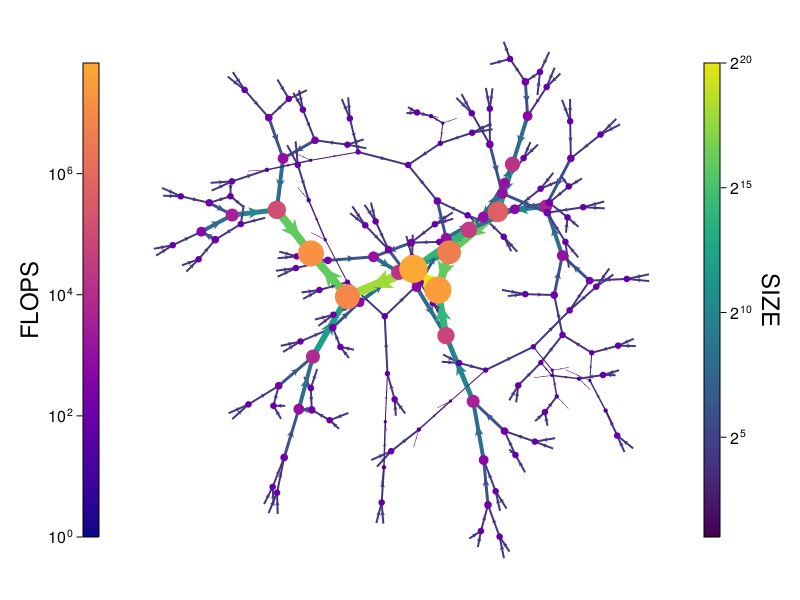

Contracting initial network..... => amount of tensors = 144
Current amount of loops in the network = 49
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9600.28515625
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9601.0
___________Extracting the TensorMaps___________
 current_mem_usage = 9603.625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9587.5078125
@before compression current_mem_usage = 9587.5078125


┌ Warning: dmrg failed to converge 3.423324707974551e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 48
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9691.671875
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9691.671875
___________Extracting the TensorMaps___________
 current_mem_usage = 9691.671875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9691.671875
@before compression current_mem_usage = 9691.671875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.8893244081175853e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


47
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9693.875
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9693.875
___________Extracting the TensorMaps___________
 current_mem_usage = 9693.875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9693.875
@before compression current_mem_usage = 9693.875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.3398720778867895e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


46
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9691.515625
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9691.515625
___________Extracting the TensorMaps___________
 current_mem_usage = 9691.515625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9691.515625
@before compression current_mem_usage = 9691.515625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.465433082053779e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


45
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9677.5
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9677.5
___________Extracting the TensorMaps___________
 current_mem_usage = 9677.5
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9677.5
@before compression current_mem_usage = 9677.5
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 5.39462046248556e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


44
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9682.70703125
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9682.70703125
___________Extracting the TensorMaps___________
 current_mem_usage = 9682.70703125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9682.70703125
@before compression current_mem_usage = 9682.70703125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 4.0775043390232627e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


43
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9677.2265625
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9677.2265625
___________Extracting the TensorMaps___________
 current_mem_usage = 9677.2265625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9677.2265625
@before compression current_mem_usage = 9677.2265625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 6.104033196178389e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


42
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9667.71875
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9667.71875
___________Extracting the TensorMaps___________
 current_mem_usage = 9667.71875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9667.71875
@before compression current_mem_usage = 9667.71875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.5039696624640786e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


41
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9665.71875
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9665.71875
___________Extracting the TensorMaps___________
 current_mem_usage = 9665.71875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9665.71875
@before compression current_mem_usage = 9665.71875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 2.931939279069555e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


40
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9669.06640625
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9669.06640625
___________Extracting the TensorMaps___________
 current_mem_usage = 9669.06640625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9669.06640625
@before compression current_mem_usage = 9669.06640625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 4.1510025725086e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


39
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9679.2890625
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9679.2890625
___________Extracting the TensorMaps___________
 current_mem_usage = 9679.2890625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9679.2890625
@before compression current_mem_usage = 9679.2890625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.6862242470775866e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


38
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9672.40234375
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9672.40234375
___________Extracting the TensorMaps___________
 current_mem_usage = 9672.40234375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9672.40234375
@before compression current_mem_usage = 9672.40234375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.8051041806838737e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


37
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9674.5
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9674.5
___________Extracting the TensorMaps___________
 current_mem_usage = 9674.5
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9674.5
@before compression current_mem_usage = 9674.5
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.9352022586435533e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


36
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9670.76953125
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9670.76953125
___________Extracting the TensorMaps___________
 current_mem_usage = 9671.015625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9671.015625
@before compression current_mem_usage = 9671.015625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 1.1102230246251565e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.72926211414416e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


35
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9664.234375
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9664.234375
___________Extracting the TensorMaps___________
 current_mem_usage = 9664.234375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9664.234375
@before compression current_mem_usage = 9664.234375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 4.1298625586809707e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


34
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9648.30859375
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9648.30859375
___________Extracting the TensorMaps___________
 current_mem_usage = 9648.30859375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9648.30859375
@before compression current_mem_usage = 9648.30859375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.5476287951146174e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


33
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9645.234375
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9645.234375
___________Extracting the TensorMaps___________
 current_mem_usage = 9645.234375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9645.234375
@before compression current_mem_usage = 9645.234375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 6.040122868877703e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


32
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9651.21875
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9651.21875
___________Extracting the TensorMaps___________
 current_mem_usage = 9651.21875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9651.21875
@before compression current_mem_usage = 9651.21875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 4.0423442419938236e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


31
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9653.05859375
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9653.05859375
___________Extracting the TensorMaps___________
 current_mem_usage = 9653.05859375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9653.05859375
@before compression current_mem_usage = 9653.05859375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.994537468750075e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


30
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9650.890625
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9650.890625
___________Extracting the TensorMaps___________
 current_mem_usage = 9650.890625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9650.890625
@before compression current_mem_usage = 9650.890625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.438824041019174e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


29
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9639.23828125
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9639.23828125
___________Extracting the TensorMaps___________
 current_mem_usage = 9639.23828125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9639.23828125
@before compression current_mem_usage = 9639.23828125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.613571510637853e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


28
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9626.8828125
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9626.8828125
___________Extracting the TensorMaps___________
 current_mem_usage = 9626.8828125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9626.8828125
@before compression current_mem_usage = 9626.8828125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 5.138618716854796e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


27
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9584.87890625
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9584.87890625
___________Extracting the TensorMaps___________
 current_mem_usage = 9584.87890625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9584.87890625
@before compression current_mem_usage = 9584.87890625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 2.7833528704240246e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


26
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9589.359375
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9589.359375
___________Extracting the TensorMaps___________
 current_mem_usage = 9589.359375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9589.359375
@before compression current_mem_usage = 9589.359375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.4421586882099857e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


25
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9586.26171875
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9586.26171875
___________Extracting the TensorMaps___________
 current_mem_usage = 9586.26171875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9586.26171875
@before compression current_mem_usage = 9586.26171875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.8874452543810545e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


24
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9580.859375
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9580.859375
___________Extracting the TensorMaps___________
 current_mem_usage = 9580.859375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9580.859375
@before compression current_mem_usage = 9580.859375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 3.01543893680119e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


23
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9592.7890625
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9592.7890625
___________Extracting the TensorMaps___________
 current_mem_usage = 9592.7890625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9592.7890625
@before compression current_mem_usage = 9592.7890625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 6.426382273150241e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


22
Extracted length node cycle = 4
____________Creating MPS___________
after mps contraction current_mem_usage = 9579.4609375
sizes in the folded loop mps = [4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9579.4609375
___________Extracting the TensorMaps___________
 current_mem_usage = 9579.4609375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9579.4609375
@before compression current_mem_usage = 9579.4609375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 5.589925287849723e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


21
Extracted length node cycle = 8
____________Creating MPS___________
after mps contraction current_mem_usage = 9587.28515625
sizes in the folded loop mps = [16, 16, 16, 16, 16, 16, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9587.28515625
___________Extracting the TensorMaps___________
 current_mem_usage = 9587.28515625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9587.28515625
@before compression current_mem_usage = 9587.28515625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 9.764042590067276e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


20
Extracted length node cycle = 7
____________Creating MPS___________
after mps contraction current_mem_usage = 9621.64453125
sizes in the folded loop mps = [16, 16, 16, 16, 16, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9621.64453125
___________Extracting the TensorMaps___________
 current_mem_usage = 9621.88671875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9621.88671875
@before compression current_mem_usage = 9621.88671875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 1.186183029248683e-15>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


19
Extracted length node cycle = 6
____________Creating MPS___________
after mps contraction current_mem_usage = 9592.6484375
sizes in the folded loop mps = [16, 64, 16, 16, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9592.6484375
___________Extracting the TensorMaps___________
 current_mem_usage = 9596.4375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9596.4375
@before compression current_mem_usage = 9596.4375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.5000000000000001
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 1.5945034317027761e-15>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


18
Extracted length node cycle = 7
____________Creating MPS___________
after mps contraction current_mem_usage = 9603.125
sizes in the folded loop mps = [16, 16, 16, 16, 16, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9603.125
___________Extracting the TensorMaps___________
 current_mem_usage = 9603.5625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9603.5625
@before compression current_mem_usage = 9603.5625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 1.02505280163649e-15>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


17
Extracted length node cycle = 7
____________Creating MPS___________
after mps contraction current_mem_usage = 9626.328125
sizes in the folded loop mps = [16, 16, 16, 16, 16, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9626.328125
___________Extracting the TensorMaps___________
 current_mem_usage = 9626.328125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9626.328125
@before compression current_mem_usage = 9626.328125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 9.526462762574288e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


16
Extracted length node cycle = 7
____________Creating MPS___________
after mps contraction current_mem_usage = 9632.84375
sizes in the folded loop mps = [16, 16, 16, 16, 16, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9632.84375
___________Extracting the TensorMaps___________
 current_mem_usage = 9632.84375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9632.84375
@before compression current_mem_usage = 9632.84375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 1.0284075232564718e-15>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


15
Extracted length node cycle = 7
____________Creating MPS___________
after mps contraction current_mem_usage = 9732.0546875
sizes in the folded loop mps = [512, 64, 64, 64, 256, 64]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9732.0546875
___________Extracting the TensorMaps___________
 current_mem_usage = 9672.48046875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9672.48046875
@before compression current_mem_usage = 9672.48046875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.4810179451054881
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 0.009724379384131118>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


14
Extracted length node cycle = 8
____________Creating MPS___________
after mps contraction current_mem_usage = 9735.109375
sizes in the folded loop mps = [16, 16, 64, 16, 64, 128, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9735.109375
___________Extracting the TensorMaps___________
 current_mem_usage = 9746.703125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9746.703125
@before compression current_mem_usage = 9746.703125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.7500000000000002
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 1.1613434288740723e-15>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


13
Extracted length node cycle = 7
____________Creating MPS___________
after mps contraction current_mem_usage = 9744.59375
sizes in the folded loop mps = [16, 128, 64, 64, 64, 64]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9744.83984375
___________Extracting the TensorMaps___________
 current_mem_usage = 9754.73828125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9754.73828125
@before compression current_mem_usage = 9754.73828125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.3974720376263159
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 0.0059548049043345085>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


12
Extracted length node cycle = 7
____________Creating MPS___________
after mps contraction current_mem_usage = 9743.03515625
sizes in the folded loop mps = [256, 256, 256, 256, 64, 64]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9743.03515625
___________Extracting the TensorMaps___________
 current_mem_usage = 9792.13671875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9792.13671875
@before compression current_mem_usage = 9792.13671875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.37681301589434457
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 0.002863286245777783>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


11
Extracted length node cycle = 7
____________Creating MPS___________
after mps contraction current_mem_usage = 9791.39453125
sizes in the folded loop mps = [16, 16, 16, 16, 64, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9791.39453125
___________Extracting the TensorMaps___________
 current_mem_usage = 9796.8515625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9796.8515625
@before compression current_mem_usage = 9796.8515625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.01935067840527227
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 9.979654999388624e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


10
Extracted length node cycle = 7
____________Creating MPS___________
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
after mps contraction current_mem_usage = 10037.859375
sizes in the folded loop mps = [512, 512, 512, 256, 512, 512]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 10037.28515625
memory got to high, running the garbage collector
memory got to high, running the garbage collector
___________Extracting the TensorMaps___________
 current_mem_usage = 9935.98828125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 10020.19921875
@before compression current_mem_usage = 10020.

┌ Warning: dmrg failed to converge 0.0058646260562080195>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.6413980093136648
Current amount of loops in the network = 9
Extracted length node cycle = 7
____________Creating MPS___________
after mps contraction current_mem_usage = 9787.28515625
sizes in the folded loop mps = [16, 16, 16, 16, 128, 128]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9787.28515625
___________Extracting the TensorMaps___________
 current_mem_usage = 9831.47265625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9831.96484375
@before compression current_mem_usage = 9831.96484375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.7435385997174879
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 0.012748189414386464>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


8
Extracted length node cycle = 7
____________Creating MPS___________
after mps contraction current_mem_usage = 9854.25
sizes in the folded loop mps = [16, 16, 16, 16, 128, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9854.49609375
___________Extracting the TensorMaps___________
 current_mem_usage = 9861.3125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 9861.3125
@before compression current_mem_usage = 9861.3125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.3188132523053817
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 0.0021601325025005953>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


7
Extracted length node cycle = 6
____________Creating MPS___________
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
after mps contraction current_mem_usage = 10453.0546875
sizes in the folded loop mps = [1024, 128, 1024, 1024, 1024]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 10453.0546875
memory got to high, running the garbage collector
memory got to high, running the garbage collector
___________Extracting the TensorMaps___________
 current_mem_usage = 10177.3203125
___________Creating the MPSKit 

┌ Warning: dmrg failed to converge 0.006010168453724398>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.6801751955754612
Current amount of loops in the network = 6
Extracted length node cycle = 7
____________Creating MPS___________
after mps contraction current_mem_usage = 9984.7265625
sizes in the folded loop mps = [64, 128, 128, 128, 64, 64]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9984.7265625
___________Extracting the TensorMaps___________
 current_mem_usage = 10022.046875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 10022.046875
@before compression current_mem_usage = 10022.046875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.028971973051957645
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 0.00016838463648667575>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


5
Extracted length node cycle = 8
____________Creating MPS___________
memory got to high, running the garbage collector
memory got to high, running the garbage collector
after mps contraction current_mem_usage = 9999.2890625
sizes in the folded loop mps = [256, 64, 256, 256, 256, 256, 256]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 9999.2890625
___________Extracting the TensorMaps___________
 current_mem_usage = 10047.74609375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 10050.94140625
@before compression current_mem_usage = 10050.94140625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.6624686592162459
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 0.011534701583424772>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


4
Extracted length node cycle = 8
____________Creating MPS___________
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
memory got to high, running the garbage collector
after mps contraction current_mem_usage = 10832.890625
sizes in the folded loop mps = [1024, 1024, 512, 128, 1024, 1024, 512]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 10832.890625
memory

┌ Warning: dmrg failed to converge 0.0005407554311014951>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.6338218251119381
Current amount of loops in the network = 3
Extracted length node cycle = 7
____________Creating MPS___________
memory got to high, running the garbage collector
memory got to high, running the garbage collector
after mps contraction current_mem_usage = 10154.2734375
sizes in the folded loop mps = [1024, 1024, 1024, 1024, 128, 1024]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 10154.2734375
memory got to high, running the garbage collector
memory got to high, running the garbage collector
___________Extracting the TensorMaps___________
 current_mem_usage = 8762.41796875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 8765.77734375
@before compression current_mem_usage = 8765.77734375


┌ Warning: dmrg failed to converge 0.007730662849220585>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.673984803770278
Current amount of loops in the network = 2
Extracted length node cycle = 9
____________Creating MPS___________
after mps contraction current_mem_usage = 8108.5546875
sizes in the folded loop mps = [256, 512, 256, 512, 256, 256, 512, 512]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 8109.046875
___________Extracting the TensorMaps___________
 current_mem_usage = 7883.6328125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7898.640625


In [6]:
# first extract the path 
tn1 = deepcopy(TN)
path = TN_tree_transform_approximate(tn1, 32, false, true)

# AS THE MAXIMAL LOOP LENGTH CORRELATES STRONGLY WITH THE MEMORY USAGE
println("The maximal loop length  = " , [length(loop) for (loop, index) in path])


In [6]:
# AS THE MAXIMAL LOOP LENGTH CORRELATES STRONGLY WITH THE MEMORY USAGE
println("The maximal loop length  = " , [length(loop) for (loop, index) in path])

The maximal loop length  = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 7, 7, 6, 7, 7, 7, 6, 7, 7, 6, 7, 9]


Any[[[Symbol("22"), Symbol("da34e5d4-2037-49de-bab0-6dcb27e87393"), Symbol("39"), Symbol("38"), Symbol("3a1ac328-0e11-4294-96a5-27eef1d4f2b5"), Symbol("21")], [Symbol("21")]], [[Symbol("20"), Symbol("37"), Symbol("36"), Symbol("ff0d4c2e-396f-4bcd-8c02-6778b40861e6"), Symbol("19")], [Symbol("19")]], [[Symbol("18"), Symbol("35"), Symbol("34"), Symbol("78d1f686-9381-42fd-bf47-a1a1836c5f79"), Symbol("17")], [Symbol("17")]], [[Symbol("32"), Symbol("33"), Symbol("48"), Symbol("e98343e4-f5b9-4347-b8c1-6680b3abfb0c"), Symbol("31")], [Symbol("31")]], [[Symbol("30"), Symbol("47"), Symbol("46"), Symbol("b2e4af1d-859b-4b98-9994-3da52bd8fdcb"), Symbol("29")], [Symbol("29")]], [[Symbol("28"), Symbol("45"), Symbol("44"), Symbol("de148f23-71de-484f-b72a-5e88f224580b"), Symbol("27")], [Symbol("27")]], [[Symbol("25"), Symbol("9bf3752a-47e6-41d5-b99e-c16446864e7c"), Symbol("42"), Symbol("43"), Symbol("26")], [Symbol("26")]], [[Symbol("24"), Symbol("25"), Symbol("41"), Symbol("40"), Symbol("22"), Symbol("

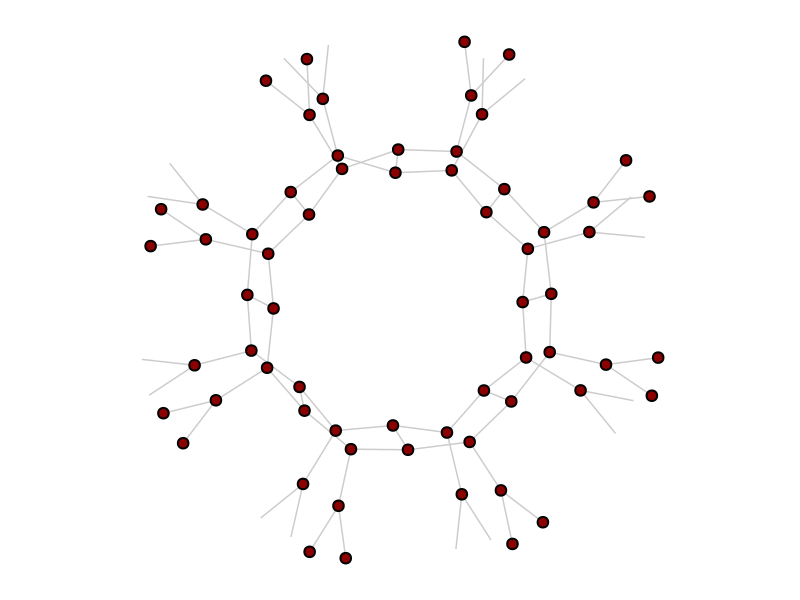

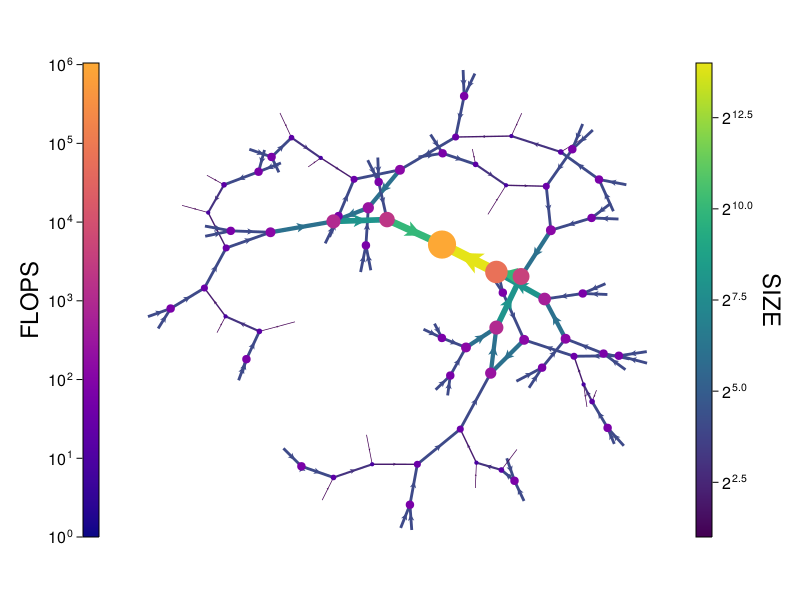

┌ Warning: dmrg failed to converge 7.611282111240223e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


8
Extracted length node cycle = 5
working on step 2 in path with length 9
[Symbol("20"), Symbol("37"), Symbol("36"), Symbol("ff0d4c2e-396f-4bcd-8c02-6778b40861e6"), Symbol("19")][Symbol("19")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6382.4296875
after mps contraction current_mem_usage = 6354.09765625
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6359.42578125
___________Extracting the TensorMaps___________
 current_mem_usage = 6354.52734375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6354.52734375
@before compression current_mem_usage = 6354.52734375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -6.661338147750939e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 6.629758253648655e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


7
Extracted length node cycle = 5
working on step 3 in path with length 9
[Symbol("18"), Symbol("35"), Symbol("34"), Symbol("78d1f686-9381-42fd-bf47-a1a1836c5f79"), Symbol("17")][Symbol("17")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6346.1640625
after mps contraction current_mem_usage = 6344.3203125
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6351.07421875
___________Extracting the TensorMaps___________
 current_mem_usage = 6343.05859375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6343.05859375
@before compression current_mem_usage = 6343.05859375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -6.661338147750939e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 5.183882108604721e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


6
Extracted length node cycle = 5
working on step 4 in path with length 9
[Symbol("32"), Symbol("33"), Symbol("48"), Symbol("e98343e4-f5b9-4347-b8c1-6680b3abfb0c"), Symbol("31")][Symbol("31")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6335.68359375
after mps contraction current_mem_usage = 6353.0234375
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6345.41015625
___________Extracting the TensorMaps___________
 current_mem_usage = 6343.06640625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6343.06640625
@before compression current_mem_usage = 6343.06640625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 5.289171593779107e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


5
Extracted length node cycle = 5
working on step 5 in path with length 9
[Symbol("30"), Symbol("47"), Symbol("46"), Symbol("b2e4af1d-859b-4b98-9994-3da52bd8fdcb"), Symbol("29")][Symbol("29")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6338.8984375
after mps contraction current_mem_usage = 6345.0234375
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6341.96484375
___________Extracting the TensorMaps___________
 current_mem_usage = 6356.83984375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6356.83984375
@before compression current_mem_usage = 6356.83984375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -6.661338147750939e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 5.252661333658985e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


4
Extracted length node cycle = 5
working on step 6 in path with length 9
[Symbol("28"), Symbol("45"), Symbol("44"), Symbol("de148f23-71de-484f-b72a-5e88f224580b"), Symbol("27")][Symbol("27")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6342.83984375
after mps contraction current_mem_usage = 6349.71484375
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6355.25390625
___________Extracting the TensorMaps___________
 current_mem_usage = 6374.1640625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6374.1640625
@before compression current_mem_usage = 6374.1640625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 6.045305980755896e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


3
Extracted length node cycle = 5
working on step 7 in path with length 9
[Symbol("25"), Symbol("9bf3752a-47e6-41d5-b99e-c16446864e7c"), Symbol("42"), Symbol("43"), Symbol("26")][Symbol("26")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6363.03125
after mps contraction current_mem_usage = 6346.79296875
sizes in the folded loop mps = [8, 4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6354.5078125
___________Extracting the TensorMaps___________
 current_mem_usage = 6368.30078125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6368.30078125
@before compression current_mem_usage = 6368.30078125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 6.458231735981193e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


2
Extracted length node cycle = 6
working on step 8 in path with length 9
[Symbol("24"), Symbol("25"), Symbol("41"), Symbol("40"), Symbol("22"), Symbol("23")][Symbol("23")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6352.71875
after mps contraction current_mem_usage = 6381.53125
sizes in the folded loop mps = [16, 4, 4, 16, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6386.40234375
___________Extracting the TensorMaps___________
 current_mem_usage = 6424.35546875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6424.35546875
@before compression current_mem_usage = 6424.35546875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 1.0453957563407018e-15>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


1
Extracted length node cycle = 15
working on step 9 in path with length 9
[Symbol("41"), Symbol("da34e5d4-2037-49de-bab0-6dcb27e87393"), Symbol("39"), Symbol("20"), Symbol("37"), Symbol("18"), Symbol("35"), Symbol("32"), Symbol("33"), Symbol("30"), Symbol("47"), Symbol("28"), Symbol("45"), Symbol("9bf3752a-47e6-41d5-b99e-c16446864e7c"), Symbol("25")][Symbol("25")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6412.63671875
after mps contraction current_mem_usage = 6353.625
sizes in the folded loop mps = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6360.74609375
___________Extracting the TensorMaps___________
 current_mem_usage = 6369.1953125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6369.1953125
@before compression current_mem_usage = 6369.1953125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPRO

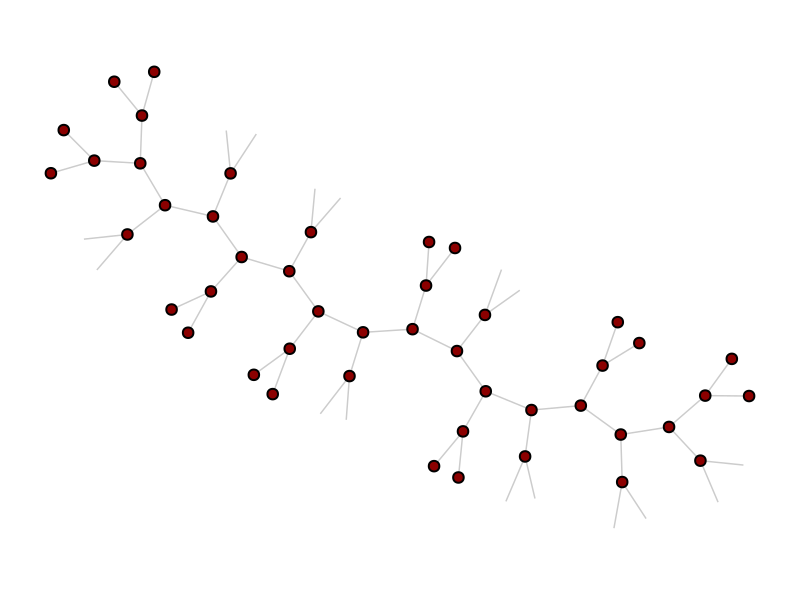

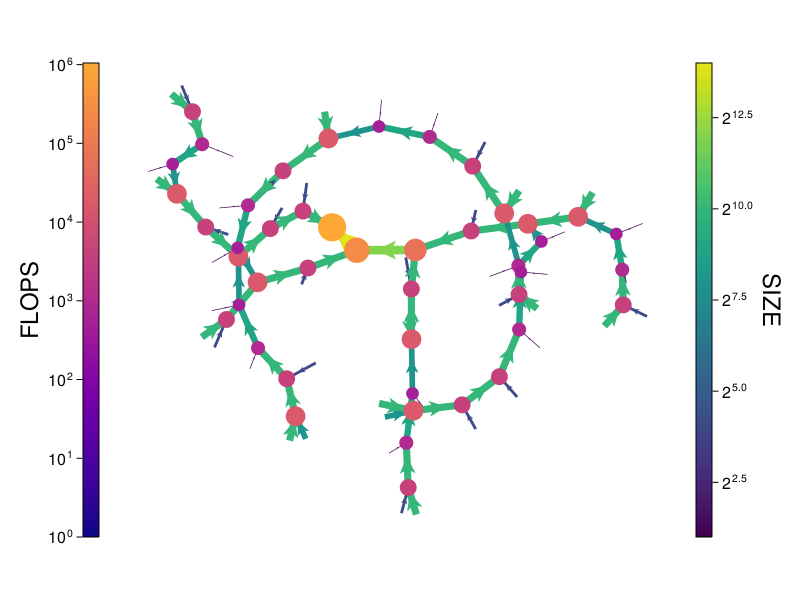

┌ Warning: dmrg failed to converge 8.695460685144891e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


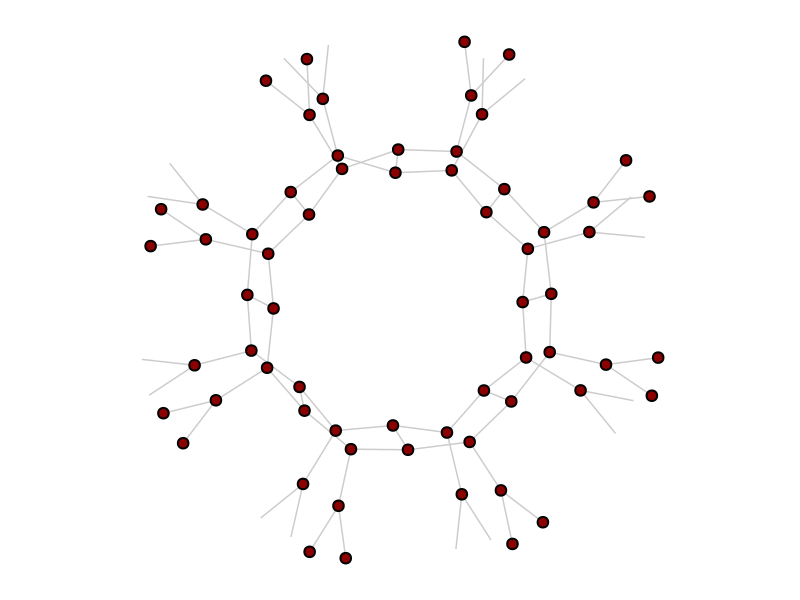

contraction_time with loops = 0.014458952[s]
contraction_time tree = 0.015184228[s]
current_mem_usage = 6373.64453125
 ---------------- GLOBAL FIDELITY ANALYSIS ------------ 
|1- |< Loop- state | Tree - state >|^2 /(|< Loop - state | Loop - state >||< Tree - state | Tree - state >|)|  = 4.440892098500626e-16
current_mem_usage = 6373.64453125
Approximate transformation finished:
global error = 4.440892098500626e-16
local_error_list = Any[-8.881784197001252e-16, -6.661338147750939e-16, -6.661338147750939e-16, -4.440892098500626e-16, -6.661338147750939e-16, -2.220446049250313e-16, -2.220446049250313e-16, -4.440892098500626e-16, -4.440892098500626e-16]
#tenosrs loop network = 64
#tenosrs tree network = 46
loop cost = 1126080
tree cost = 1617920
Contracting initial network..... => amount of tensors = 64
Current amount of loops in the network = 9
Extracted length node cycle = 6
working on step 1 in path with length 9
[Symbol("22"), Symbol("da34e5d4-2037-49de-bab0-6dcb27e87393"), Symbol("39")

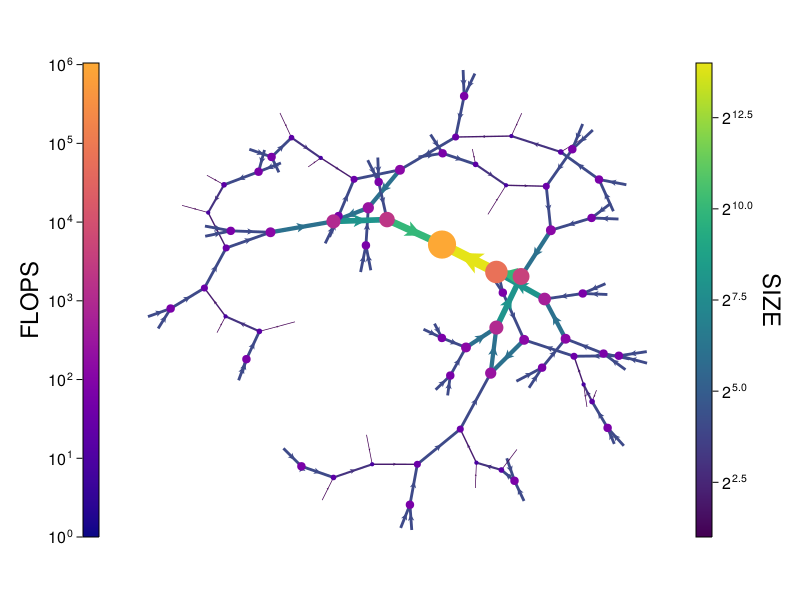

┌ Warning: dmrg failed to converge 7.651562284783149e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


8
Extracted length node cycle = 5
working on step 2 in path with length 9
[Symbol("20"), Symbol("37"), Symbol("36"), Symbol("ff0d4c2e-396f-4bcd-8c02-6778b40861e6"), Symbol("19")][Symbol("19")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6369.47265625
after mps contraction current_mem_usage = 6391.8984375
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6389.6171875
___________Extracting the TensorMaps___________
 current_mem_usage = 6394.94140625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6394.94140625
@before compression current_mem_usage = 6394.94140625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 5.392103116110069e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


7
Extracted length node cycle = 5
working on step 3 in path with length 9
[Symbol("18"), Symbol("35"), Symbol("34"), Symbol("78d1f686-9381-42fd-bf47-a1a1836c5f79"), Symbol("17")][Symbol("17")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6390.76953125
after mps contraction current_mem_usage = 6378.28125
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6370.6328125
___________Extracting the TensorMaps___________
 current_mem_usage = 6391.83203125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6391.83203125
@before compression current_mem_usage = 6391.83203125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 5.994462314200118e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


6
Extracted length node cycle = 5
working on step 4 in path with length 9
[Symbol("32"), Symbol("33"), Symbol("48"), Symbol("e98343e4-f5b9-4347-b8c1-6680b3abfb0c"), Symbol("31")][Symbol("31")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6387.640625
after mps contraction current_mem_usage = 6370.84765625
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6378.62890625
___________Extracting the TensorMaps___________
 current_mem_usage = 6401.19140625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6401.19140625
@before compression current_mem_usage = 6401.19140625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -6.661338147750939e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 7.383320951168997e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


5
Extracted length node cycle = 5
working on step 5 in path with length 9
[Symbol("30"), Symbol("47"), Symbol("46"), Symbol("b2e4af1d-859b-4b98-9994-3da52bd8fdcb"), Symbol("29")][Symbol("29")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6408.98828125
after mps contraction current_mem_usage = 6379.32421875
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6377.734375
___________Extracting the TensorMaps___________
 current_mem_usage = 6399.296875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6399.296875
@before compression current_mem_usage = 6399.296875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 4.42677503202276e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


4
Extracted length node cycle = 5
working on step 6 in path with length 9
[Symbol("28"), Symbol("45"), Symbol("44"), Symbol("de148f23-71de-484f-b72a-5e88f224580b"), Symbol("27")][Symbol("27")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6395.70703125
after mps contraction current_mem_usage = 6369.20703125
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6377.33984375
___________Extracting the TensorMaps___________
 current_mem_usage = 6390.48828125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6390.48828125
@before compression current_mem_usage = 6390.48828125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 8.506362331294408e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


3
Extracted length node cycle = 5
working on step 7 in path with length 9
[Symbol("25"), Symbol("9bf3752a-47e6-41d5-b99e-c16446864e7c"), Symbol("42"), Symbol("43"), Symbol("26")][Symbol("26")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6396.64453125
after mps contraction current_mem_usage = 6381.73828125
sizes in the folded loop mps = [8, 4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 6381.6484375
___________Extracting the TensorMaps___________
 current_mem_usage = 6386.5625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 6386.5625
@before compression current_mem_usage = 6386.5625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 9.725301124889002e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


2
Extracted length node cycle = 6
working on step 8 in path with length 9
[Symbol("24"), Symbol("25"), Symbol("41"), Symbol("40"), Symbol("22"), Symbol("23")][Symbol("23")]
____________Creating MPS___________
before mps contraction current_mem_usage = 6382.64453125
after mps contraction current_mem_usage = 7194.12109375
sizes in the folded loop mps = [16, 4, 4, 16, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7298.05078125
___________Extracting the TensorMaps___________
 current_mem_usage = 7418.23046875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7418.23046875
@before compression current_mem_usage = 7418.23046875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.24999999999999978
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 1.0794777789482933e-15>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


1
Extracted length node cycle = 15
working on step 9 in path with length 9
[Symbol("41"), Symbol("da34e5d4-2037-49de-bab0-6dcb27e87393"), Symbol("39"), Symbol("20"), Symbol("37"), Symbol("18"), Symbol("35"), Symbol("32"), Symbol("33"), Symbol("30"), Symbol("47"), Symbol("28"), Symbol("45"), Symbol("9bf3752a-47e6-41d5-b99e-c16446864e7c"), Symbol("25")][Symbol("25")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7432.18359375
after mps contraction current_mem_usage = 7467.1328125
sizes in the folded loop mps = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7466.96484375
___________Extracting the TensorMaps___________
 current_mem_usage = 7466.30078125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7466.30078125
@before compression current_mem_usage = 7466.30078125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS 

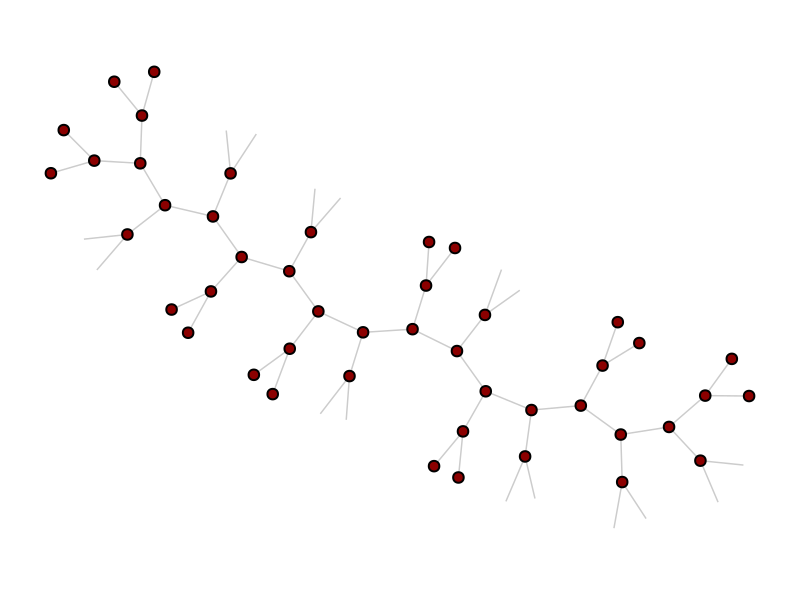

┌ Warning: dmrg failed to converge 2.3183845242340902e-7>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


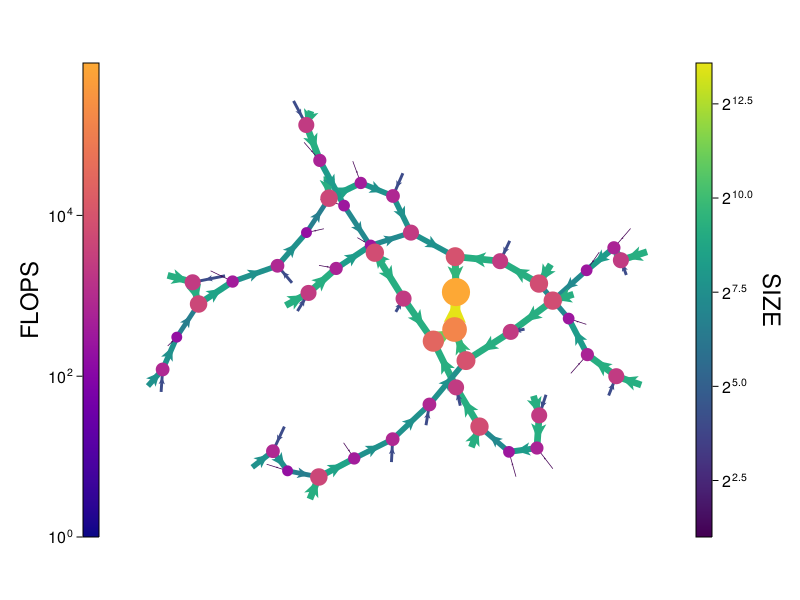

7459.3984375
cost of loopcontraction = 1126080
cost of treecontraction = 1057440
contraction_time with loops = 0.017789063[s]
contraction_time tree = 0.310305419[s]
current_mem_usage = 7444.4765625
 ---------------- GLOBAL FIDELITY ANALYSIS ------------ 
|1- |< Loop- state | Tree - state >|^2 /(|< Loop - state | Loop - state >||< Tree - state | Tree - state >|)|  = 0.13308666551561088
current_mem_usage = 7444.4765625
Approximate transformation finished:
global error = 0.13308666551561088
local_error_list = Any[-4.440892098500626e-16, 0.0, 4.440892098500626e-16, -6.661338147750939e-16, -4.440892098500626e-16, -4.440892098500626e-16, 0.0, 0.24999999999999978, 0.1462091491983415]
#tenosrs loop network = 64
#tenosrs tree network = 46
loop cost = 1126080
tree cost = 1057440
Contracting initial network..... => amount of tensors = 64
Current amount of loops in the network = 9
Extracted length node cycle = 6
working on step 1 in path with length 9
[Symbol("22"), Symbol("da34e5d4-2037-49de-bab0

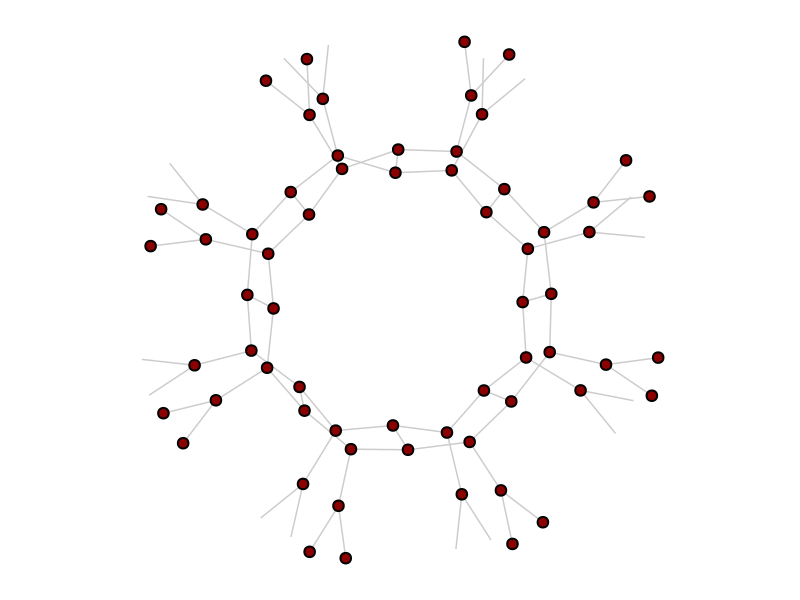

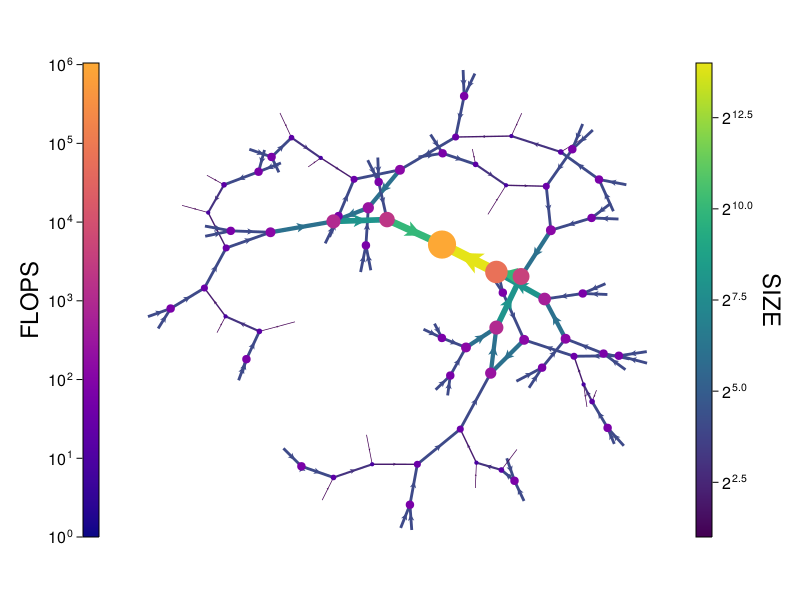

┌ Warning: dmrg failed to converge 8.121344035882332e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


8
Extracted length node cycle = 5
working on step 2 in path with length 9
[Symbol("20"), Symbol("37"), Symbol("36"), Symbol("ff0d4c2e-396f-4bcd-8c02-6778b40861e6"), Symbol("19")][Symbol("19")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7389.4453125
after mps contraction current_mem_usage = 7379.30859375
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7387.30859375
___________Extracting the TensorMaps___________
 current_mem_usage = 7364.71484375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7364.71484375
@before compression current_mem_usage = 7364.71484375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 4.852087090780353e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


7
Extracted length node cycle = 5
working on step 3 in path with length 9
[Symbol("18"), Symbol("35"), Symbol("34"), Symbol("78d1f686-9381-42fd-bf47-a1a1836c5f79"), Symbol("17")][Symbol("17")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7371.046875
after mps contraction current_mem_usage = 7369.71875
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7370.4140625
___________Extracting the TensorMaps___________
 current_mem_usage = 7323.1640625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7323.1640625
@before compression current_mem_usage = 7323.1640625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 5.052544053529154e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


6
Extracted length node cycle = 5
working on step 4 in path with length 9
[Symbol("32"), Symbol("33"), Symbol("48"), Symbol("e98343e4-f5b9-4347-b8c1-6680b3abfb0c"), Symbol("31")][Symbol("31")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7315.140625
after mps contraction current_mem_usage = 7356.21875
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7332.140625
___________Extracting the TensorMaps___________
 current_mem_usage = 7352.3359375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7352.3359375
@before compression current_mem_usage = 7352.3359375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 6.408548732799613e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


5
Extracted length node cycle = 5
working on step 5 in path with length 9
[Symbol("30"), Symbol("47"), Symbol("46"), Symbol("b2e4af1d-859b-4b98-9994-3da52bd8fdcb"), Symbol("29")][Symbol("29")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7335.9765625
after mps contraction current_mem_usage = 7292.9921875
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7311.109375
___________Extracting the TensorMaps___________
 current_mem_usage = 7296.86328125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7296.86328125
@before compression current_mem_usage = 7296.86328125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 7.410214347911645e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


4
Extracted length node cycle = 5
working on step 6 in path with length 9
[Symbol("28"), Symbol("45"), Symbol("44"), Symbol("de148f23-71de-484f-b72a-5e88f224580b"), Symbol("27")][Symbol("27")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7295.76171875
after mps contraction current_mem_usage = 7292.86328125
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7299.5703125
___________Extracting the TensorMaps___________
 current_mem_usage = 7272.0234375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7272.26953125
@before compression current_mem_usage = 7272.26953125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.0
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 6.268259515318131e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


3
Extracted length node cycle = 5
working on step 7 in path with length 9
[Symbol("25"), Symbol("9bf3752a-47e6-41d5-b99e-c16446864e7c"), Symbol("42"), Symbol("43"), Symbol("26")][Symbol("26")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7277.90234375
after mps contraction current_mem_usage = 7270.75390625
sizes in the folded loop mps = [8, 4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7281.4765625
___________Extracting the TensorMaps___________
 current_mem_usage = 7278.6015625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7278.6015625
@before compression current_mem_usage = 7278.6015625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 7.459841648133747e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


2
Extracted length node cycle = 6
working on step 8 in path with length 9
[Symbol("24"), Symbol("25"), Symbol("41"), Symbol("40"), Symbol("22"), Symbol("23")][Symbol("23")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7287.89453125
after mps contraction current_mem_usage = 7302.48828125
sizes in the folded loop mps = [16, 4, 4, 16, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7306.3515625
___________Extracting the TensorMaps___________
 current_mem_usage = 7324.12890625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7324.12890625
@before compression current_mem_usage = 7324.12890625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.5
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 1.1710332464119944e-15>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


1
Extracted length node cycle = 15
working on step 9 in path with length 9
[Symbol("41"), Symbol("da34e5d4-2037-49de-bab0-6dcb27e87393"), Symbol("39"), Symbol("20"), Symbol("37"), Symbol("18"), Symbol("35"), Symbol("32"), Symbol("33"), Symbol("30"), Symbol("47"), Symbol("28"), Symbol("45"), Symbol("9bf3752a-47e6-41d5-b99e-c16446864e7c"), Symbol("25")][Symbol("25")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7319.6796875
after mps contraction current_mem_usage = 7261.64453125
sizes in the folded loop mps = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7278.328125
___________Extracting the TensorMaps___________
 current_mem_usage = 7306.10546875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7306.10546875
@before compression current_mem_usage = 7306.10546875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | 

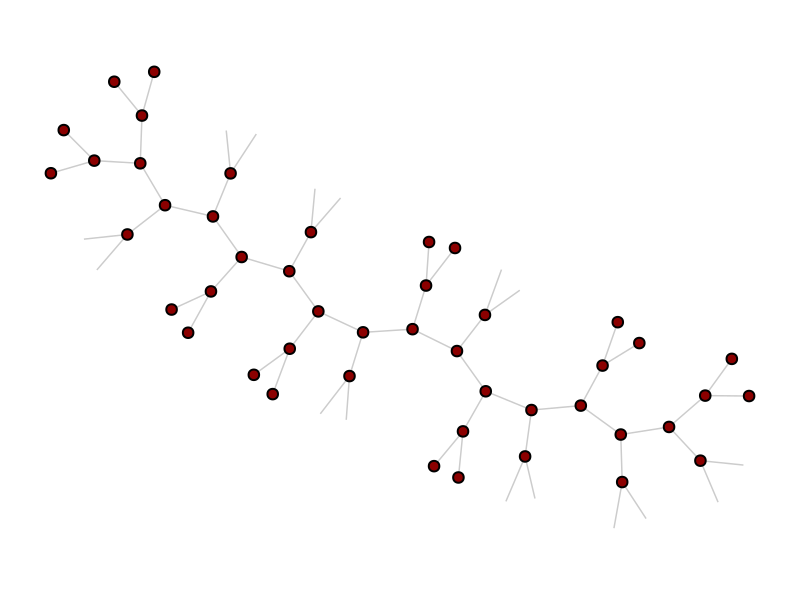

┌ Warning: dmrg failed to converge 9.029521409493978e-6>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


46
current_mem_usage = 7308.89453125
current_mem_usage = 7328.9921875
cost of loopcontraction = 1126080
cost of treecontraction = 637952
contraction_time with loops = 0.013481221[s]
contraction_time tree = 0.106031448[s]
current_mem_usage = 7325.50390625
 ---------------- GLOBAL FIDELITY ANALYSIS ------------ 
|1- |< Loop- state | Tree - state >|^2 /(|< Loop - state | Loop - state >||< Tree - state | Tree - state >|)|  = 0.72593669234202
current_mem_usage = 7325.50390625
Approximate transformation finished:
global error = 0.72593669234202
local_error_list = Any[-2.220446049250313e-16, -2.220446049250313e-16, -2.220446049250313e-16, -2.220446049250313e-16, -2.220446049250313e-16, 0.0, -4.440892098500626e-16, 0.5, 0.2319957724809919]
#tenosrs loop network = 64
#tenosrs tree network = 46
loop cost = 1126080
tree cost = 637952
Contracting initial network..... => amount of tensors = 64
Current amount of loops in the network = 9
Extracted length node cycle = 6
working on step 1 in path with 

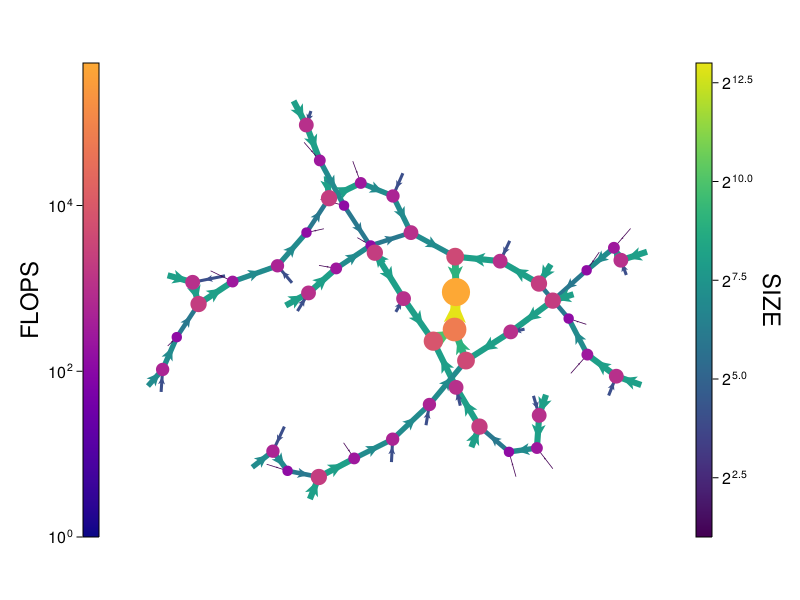

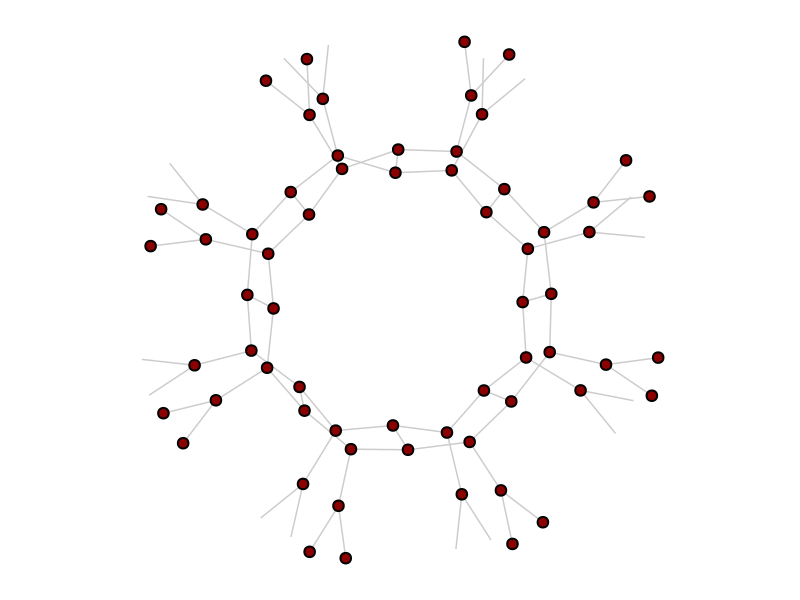

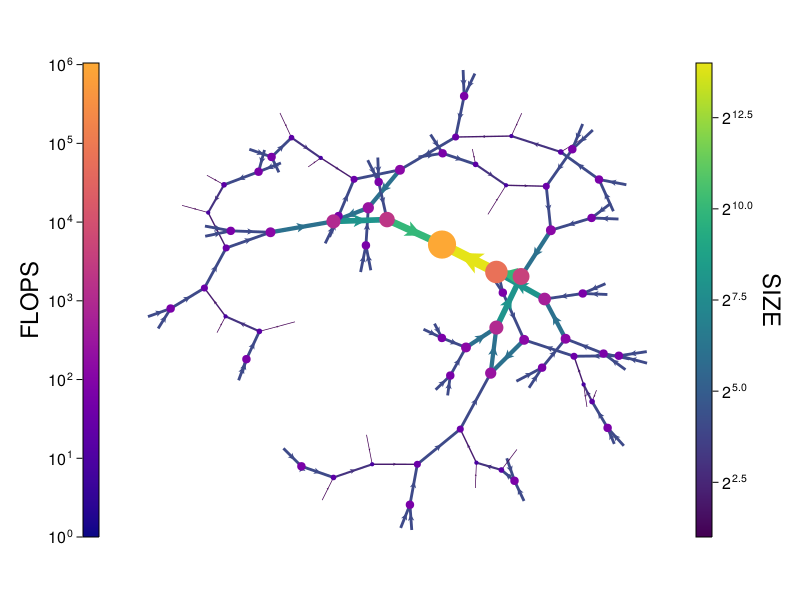

┌ Warning: dmrg failed to converge 6.820122209991035e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


8
Extracted length node cycle = 5
working on step 2 in path with length 9
[Symbol("20"), Symbol("37"), Symbol("36"), Symbol("ff0d4c2e-396f-4bcd-8c02-6778b40861e6"), Symbol("19")][Symbol("19")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7292.33203125
after mps contraction current_mem_usage = 7282.2265625
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7292.19140625
___________Extracting the TensorMaps___________
 current_mem_usage = 7287.328125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7287.328125
@before compression current_mem_usage = 7287.328125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 5.212706939738365e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


7
Extracted length node cycle = 5
working on step 3 in path with length 9
[Symbol("18"), Symbol("35"), Symbol("34"), Symbol("78d1f686-9381-42fd-bf47-a1a1836c5f79"), Symbol("17")][Symbol("17")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7271.73828125
after mps contraction current_mem_usage = 7246.29296875
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7250.97265625
___________Extracting the TensorMaps___________
 current_mem_usage = 7275.8046875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7275.8046875
@before compression current_mem_usage = 7275.8046875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 5.833754087214467e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


6
Extracted length node cycle = 5
working on step 4 in path with length 9
[Symbol("32"), Symbol("33"), Symbol("48"), Symbol("e98343e4-f5b9-4347-b8c1-6680b3abfb0c"), Symbol("31")][Symbol("31")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7279.6640625
after mps contraction current_mem_usage = 7247.48046875
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7256.40625
___________Extracting the TensorMaps___________
 current_mem_usage = 7290.828125
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7290.828125
@before compression current_mem_usage = 7290.828125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 5.975892626467257e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


5
Extracted length node cycle = 5
working on step 5 in path with length 9
[Symbol("30"), Symbol("47"), Symbol("46"), Symbol("b2e4af1d-859b-4b98-9994-3da52bd8fdcb"), Symbol("29")][Symbol("29")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7254.98046875
after mps contraction current_mem_usage = 7255.63671875
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7268.0703125
___________Extracting the TensorMaps___________
 current_mem_usage = 7285.4921875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7285.4921875
@before compression current_mem_usage = 7285.4921875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -4.440892098500626e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 5.518929431555011e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


4
Extracted length node cycle = 5
working on step 6 in path with length 9
[Symbol("28"), Symbol("45"), Symbol("44"), Symbol("de148f23-71de-484f-b72a-5e88f224580b"), Symbol("27")][Symbol("27")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7266.515625
after mps contraction current_mem_usage = 7275.8359375
sizes in the folded loop mps = [4, 4, 4, 8]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7278.55859375
___________Extracting the TensorMaps___________
 current_mem_usage = 7286.875
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7286.875
@before compression current_mem_usage = 7286.875
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = -2.220446049250313e-16
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 6.0563019007035e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


3
Extracted length node cycle = 5
working on step 7 in path with length 9
[Symbol("25"), Symbol("9bf3752a-47e6-41d5-b99e-c16446864e7c"), Symbol("42"), Symbol("43"), Symbol("26")][Symbol("26")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7281.95703125
after mps contraction current_mem_usage = 7322.265625
sizes in the folded loop mps = [8, 4, 4, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7333.09375
___________Extracting the TensorMaps___________
 current_mem_usage = 7349.30859375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7349.30859375
@before compression current_mem_usage = 7349.30859375
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.4999999999999998
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 8.385258573751469e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


2
Extracted length node cycle = 6
working on step 8 in path with length 9
[Symbol("24"), Symbol("25"), Symbol("41"), Symbol("40"), Symbol("22"), Symbol("23")][Symbol("23")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7350.73828125
after mps contraction current_mem_usage = 7294.6640625
sizes in the folded loop mps = [8, 4, 4, 8, 4]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7315.4296875
___________Extracting the TensorMaps___________
 current_mem_usage = 7319.02734375
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7319.51953125
@before compression current_mem_usage = 7319.51953125
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS | APPROX - MPS >|^2 /(|< FULL - MPS | FULL - MPS >||< APPROX - MPS | APPROX - MPS >|)|  = 0.30564727885052867
Current amount of loops in the network = 

┌ Warning: dmrg failed to converge 0.0003364018530193304>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


1
Extracted length node cycle = 15
working on step 9 in path with length 9
[Symbol("41"), Symbol("da34e5d4-2037-49de-bab0-6dcb27e87393"), Symbol("39"), Symbol("20"), Symbol("37"), Symbol("18"), Symbol("35"), Symbol("32"), Symbol("33"), Symbol("30"), Symbol("47"), Symbol("28"), Symbol("45"), Symbol("9bf3752a-47e6-41d5-b99e-c16446864e7c"), Symbol("25")][Symbol("25")]
____________Creating MPS___________
before mps contraction current_mem_usage = 7324.42578125
after mps contraction current_mem_usage = 7304.60546875
sizes in the folded loop mps = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
___________Starting MPSKit conversion and compression___________
current_mem_usage = 7342.1640625
___________Extracting the TensorMaps___________
 current_mem_usage = 7322.50390625
___________Creating the MPSKit MPSs___________
 current_mem_usage = 7322.50390625
@before compression current_mem_usage = 7322.50390625
_____________Local fidelity analysis MPSKit.jl_____________
|1- |< FULL - MPS 

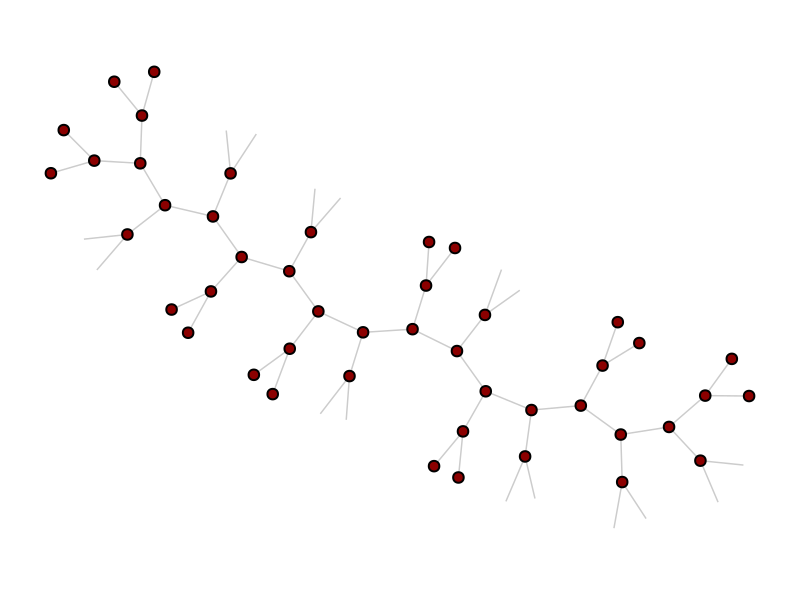

┌ Warning: dmrg failed to converge 0.00021640476959249304>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


46
current_mem_usage = 7324.15625
current_mem_usage = 7339.359375
cost of loopcontraction = 1126080
cost of treecontraction = 288512
contraction_time with loops = 0.014375062[s]
contraction_time tree = 0.133069791[s]
current_mem_usage = 7351.63671875
 ---------------- GLOBAL FIDELITY ANALYSIS ------------ 
|1- |< Loop- state | Tree - state >|^2 /(|< Loop - state | Loop - state >||< Tree - state | Tree - state >|)|  = 0.7931545858746375
current_mem_usage = 7353.11328125
Approximate transformation finished:
global error = 0.7931545858746375
local_error_list = Any[0.4999999999999998, 2.220446049250313e-16, -2.220446049250313e-16, -4.440892098500626e-16, -4.440892098500626e-16, -2.220446049250313e-16, 0.4999999999999998, 0.30564727885052867, 0.6786766078758482]
#tenosrs loop network = 64
#tenosrs tree network = 46
loop cost = 1126080
tree cost = 288512


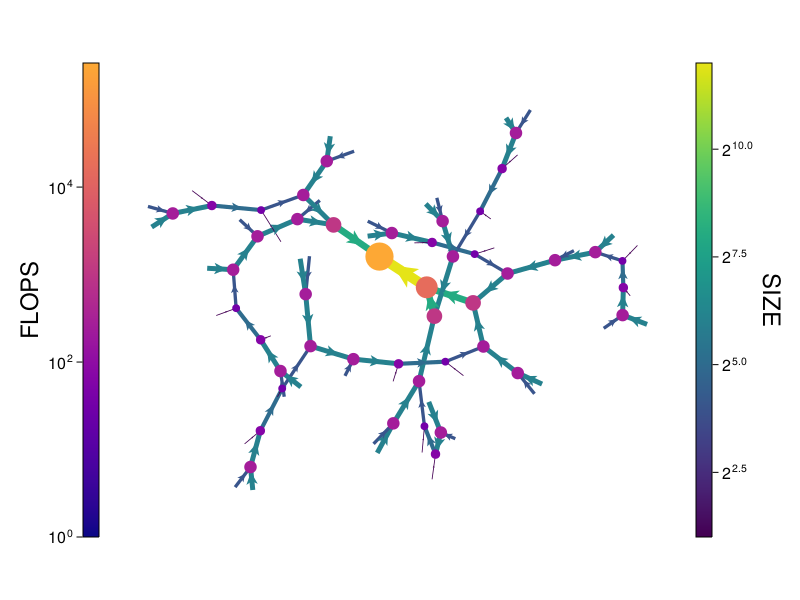

In [19]:
println(path)

chi_max_list = reverse(collect(4:4:16))


local_error_lists = []
global_fidelity_list = []
tree_cost_list = []
loop_cost_list = []
maximal_memory_usage = []
# FOR EVERY VALUE OF χ - follow the same path!
for chi_max in chi_max_list
    tn1 = deepcopy(TN)
    global local_error_list = []
    tn1, globalF, tree_cost, loop_cost, local_error_list = TN_tree_transform_approximate(tn1, chi_max, true, false, path)
    push!(local_error_lists, local_error_lists)
    push!(tree_cost_list, tree_cost)
    push!(loop_cost_list, loop_cost)
    push!(global_fidelity_list, globalF)

    println("Approximate transformation finished:")
    println("global error = ", globalF)
    println("local_error_list = ", local_error_list)
    println("#tenosrs loop network = ", length(Tenet.tensors(TN)))
    println("#tenosrs tree network = ", length(Tenet.tensors(tn1)))
    println("loop cost = ", loop_cost)
    println("tree cost = ", tree_cost)
    if chi_max == chi_max_list[1]
        maximal_memory_usage = memory_usage_throughout_approximation_process
    end
end

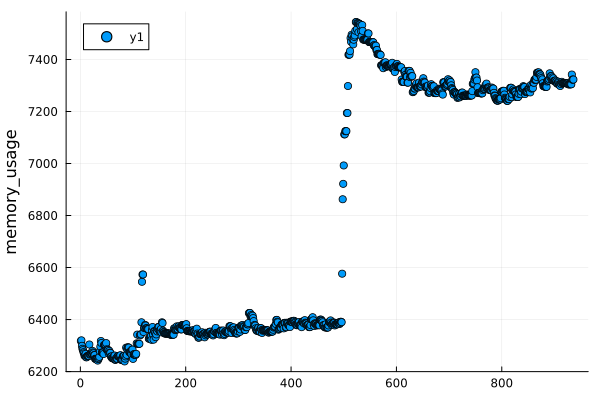

In [20]:
p = (Plots.scatter!(collect(1:length(memory_usage_throughout_approximation_process)), memory_usage_throughout_approximation_process, ylabel="memory_usage"))
display(p)

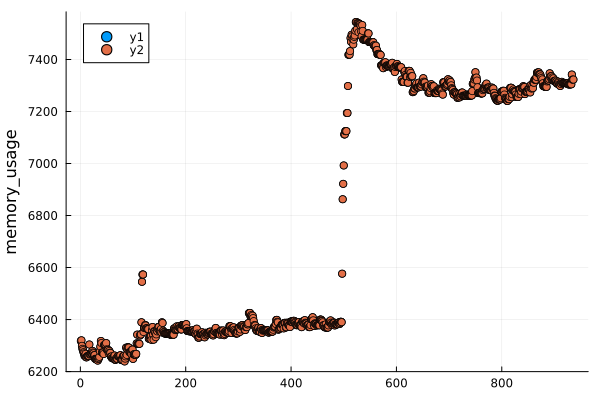

In [21]:
p = (Plots.scatter!(collect(1:length(maximal_memory_usage)), maximal_memory_usage, ylabel="memory_usage"))
display(p)

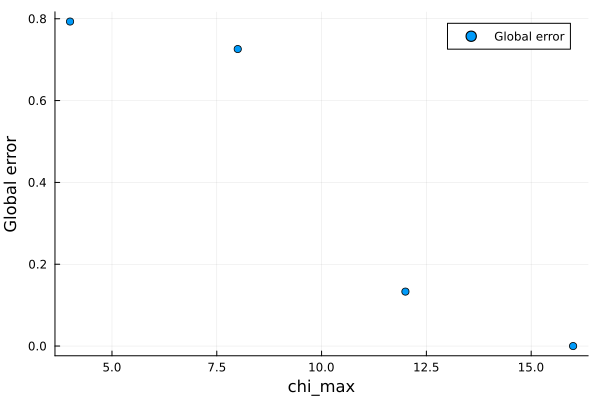

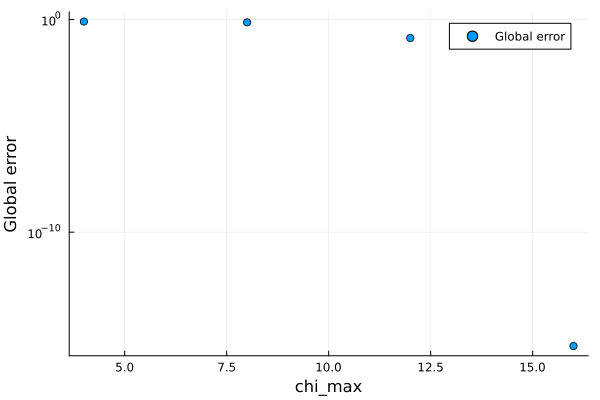

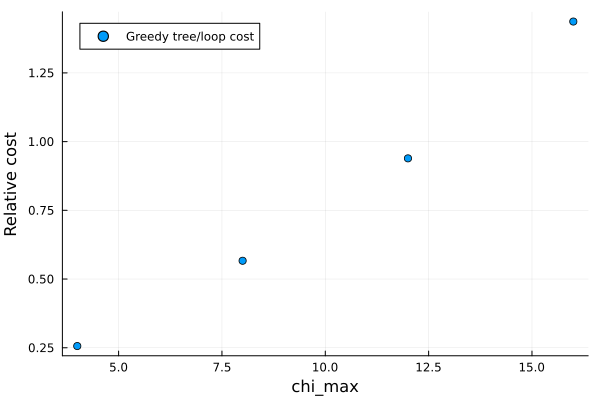

[4.440892098500626e-16, 0.13308666551561088, 0.72593669234202, 0.7931545858746375]


In [22]:
global_fidelity_list = [x == 0 ? 1e-16 : x for x in global_fidelity_list]
local_error_list = [x == 0 ? 1e-16 : x for x in local_error_list]

println(global_fidelity_list)

p = Plots.scatter(chi_max_list, global_fidelity_list, label="Global error", xlabel="chi_max", ylabel="Global error")
display(p)

p = Plots.scatter(chi_max_list, global_fidelity_list, label="Global error", xlabel="chi_max", ylabel="Global error", yscale=:log10)
display(p)

p = Plots.scatter(chi_max_list, tree_cost_list./loop_cost_list, label="Greedy tree/loop cost", xlabel="chi_max", ylabel="Relative cost")
display(p)